<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/ECG_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d shayanfazeli/heartbeat

100% 98.8M/98.8M [00:05<00:00, 24.5MB/s]
100% 98.8M/98.8M [00:05<00:00, 17.7MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/heartbeat.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight, resample
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input,  Softmax, Add,  AveragePooling1D, ZeroPadding1D,Activation
from keras import backend as K
from keras.models import Model
from keras.initializers import glorot_uniform

In [5]:
train_df=pd.read_csv('/content/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/mitbih_test.csv',header=None)

In [6]:
train_df.shape

(87554, 188)

In [7]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
test_df.shape

(21892, 188)

In [9]:
train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [10]:
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


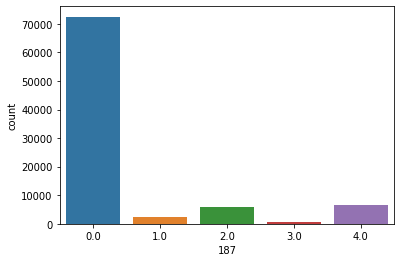

In [11]:
sns.countplot(x=187, data = train_df) 

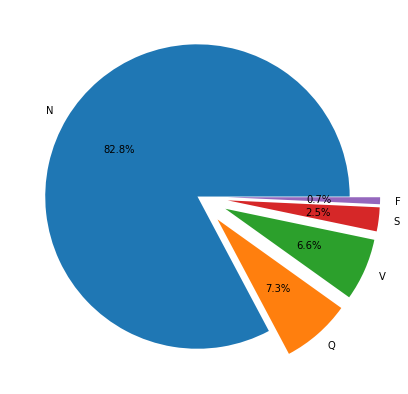

In [12]:
plt.figure(figsize=(7,7))
explode = (0, 0.2,0.2,0.2,0.2)
plt.pie(train_df[187].value_counts(), labels=['N','Q','V','S','F'], autopct='%1.1f%%', explode=explode)
plt.show()

In [13]:
x = train_df.drop(187,axis=1)
y = train_df[187].astype('int64')
print(x.shape)
print(y.shape)

x_test = test_df.drop(187,axis=1)
y_test = test_df[187].astype('int64')
print(x_test.shape)
print(y_test.shape)

(87554, 187)
(87554,)
(21892, 187)
(21892,)


In [14]:
x_train,x_val,y_train,y_val = train_test_split(x,y.values,random_state=42,stratify=y.values,shuffle=True,train_size=0.75)

In [15]:
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)

The shape of training data :  (65665, 187) (65665,)
The shape of validation data :  (21889, 187) (21889,)


In [16]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [17]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
x_train = np.expand_dims(x_train, 2)
x_val = np.expand_dims(x_val, 2)
x_test = np.expand_dims(x_test, 2)
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)
print("The shape of testing data : ",x_test.shape,y_test.shape)

The shape of training data :  (65665, 187, 1) (65665, 5)
The shape of validation data :  (21889, 187, 1) (21889, 5)
The shape of testing data :  (21892, 187, 1) (21892, 5)


In [19]:
def create_vgg16_model():
    model = Sequential([
    # 1st Conv Block
        Conv1D (filters =64, kernel_size =3, padding ='same',input_shape=(x_train.shape[1],1), activation='relu'),
        Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 2nd Conv Block
        Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 3rd Conv block  
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 4th Conv block
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),

    # 5th Conv block
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # Fully connected layers  
        Flatten(),
        Dense(units = 4096, activation ='relu'),
        Dense(units = 4096, activation ='relu'), 
        Dense(units = 5, activation ='softmax')
    ])
    
    return model

vgg16_model = create_vgg16_model()
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 187, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 94, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 94, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 47, 128)          0         
 1D)                                                    

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True)]

In [21]:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
vgg16_history = vgg16_model.fit(x=x_train,y= y_train,batch_size=32, epochs=30,callbacks=callbacks, verbose=1, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/30
2053/2053 [==============================] - 59s 23ms/step - loss: 0.2849 - accuracy: 0.9252 - val_loss: 0.1975 - val_accuracy: 0.9448
Epoch 2/30
2053/2053 [==============================] - 47s 23ms/step - loss: 0.1531 - accuracy: 0.9574 - val_loss: 0.1495 - val_accuracy: 0.9604
Epoch 3/30
2053/2053 [==============================] - 47s 23ms/step - loss: 0.1327 - accuracy: 0.9649 - val_loss: 0.1311 - val_accuracy: 0.9694
Epoch 4/30
2053/2053 [==============================] - 47s 23ms/step - loss: 0.1191 - accuracy: 0.9687 - val_loss: 0.1065 - val_accuracy: 0.9699
Epoch 5/30
2053/2053 [==============================] - 47s 23ms/step - loss: 0.1062 - accuracy: 0.9711 - val_loss: 0.0945 - val_accuracy: 0.9746
Epoch 6/30
2053/2053 [==============================] - 45s 22ms/step - loss: 0.0937 - accuracy: 0.9746 - val_loss: 0.1153 - val_accuracy: 0.9646
Epoch 7/30
2053/2053 [==============================] - 47s 23ms/step - loss: 0.0897 - accuracy: 0.9755 - val_loss: 0.0928 -

In [23]:
from keras.models import load_model
best_model=load_model('best_weights.h5')
results = best_model.evaluate(x_test,y_test)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

685/685 [==============================] - 5s 7ms/step - loss: 0.0860 - accuracy: 0.9803
Test Loss: 0.08604
Test Accuracy: 98.03%


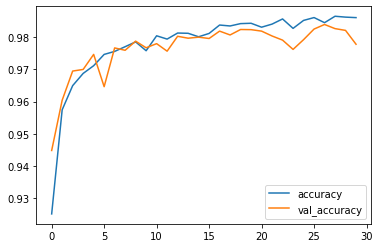

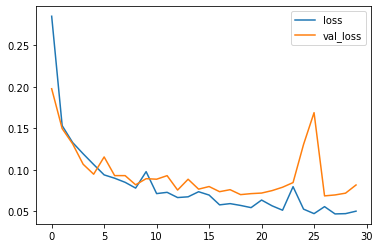

In [24]:
pd.DataFrame(vgg16_history.history)
pd.DataFrame(vgg16_history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(vgg16_history.history)[['loss', 'val_loss']].plot()

685/685 [==============================] - 4s 5ms/step


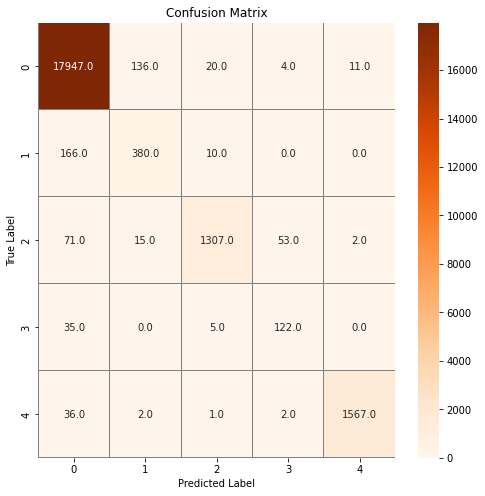

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = vgg16_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()